In [35]:
import skfuzzy
import numpy as np
import matplotlib.pyplot as plt
from utils.datastore import *
from sklearn.metrics import f1_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix

In [7]:
ds = DataStore()
D = ds.build_datasets()
L = D[0]['label']
L.unique()

array(['BRICKFACE', 'SKY', 'FOLIAGE', 'CEMENT', 'WINDOW', 'PATH', 'GRASS'],
      dtype=object)

In [8]:
# Hyperparameters:
metric = 'cityblock'
c = 7
epsilon = 1e-06
T = 100
m_list = [1.1,1.6,2.0]
niter = 50

all_results = {}

for i,Di in enumerate(D,start=1):
    Di = Di.drop(columns=['label'],axis=1)
    all_results[str(i)] = {}
    for m in m_list:
        results = []
        for j in range(niter):
            results.append(
                skfuzzy.cmeans(Di.transpose(), c, m, error=epsilon, metric=metric, 
                        maxiter=T, init=None)
            )
        all_results[str(i)][str(m)] = results 

In [69]:
best_results = {}

best_J_results = {'Di': [], 'm': [], 'J': []}

for dataset,mresults in all_results.items():
    best_results[dataset] = {}
    for m,results in mresults.items():
        results.sort(key=lambda r: r[4][-1])
        best_results[dataset][m] = results[0]
        best_J_results['Di'].append(dataset)
        best_J_results['m'].append(m)
        best_J_results['J'].append(results[0][4][-1])
        #print("Dataset: {0} --- m: {1} --- J: {2}".format(dataset,m,results[0][4][-1]))
    #print("\n")
    
best_J_results = pd.DataFrame(data=best_J_results)
best_J_results

,Di,m,J
0,1,1.1,1.464735e+06
1,1,1.6,1.145190e+06
2,1,2.0,8.743696e+05
3,2,1.1,3.083889e+06
4,2,1.6,2.744887e+06
5,2,2.0,2.106153e+06
6,3,1.1,1.362306e+07
7,3,1.6,1.098311e+07
8,3,2.0,6.997221e+06


In [72]:
# Protótipos

for dataset,mresults in best_results.items():
    for m,results in mresults.items():        
        print("Dataset: {0} --- m: {1}\nProtótipos:\n".format(dataset,m))
        print(results[0],"\n")

Dataset: 1 --- m: 1.1
Protótipos:

[[4.63975410e-16 9.82072336e-03 3.28206842e+00 1.45774055e+01
  1.09673984e+01 9.49860474e+01]
 [1.47678523e-02 4.14313130e-03 1.70182422e+00 1.77301420e+00
  2.04845696e+00 2.18262202e+00]
 [6.64532739e-17 3.70302617e-02 2.70184910e+01 7.30023734e+02
  1.46101320e+01 1.99407056e+02]
 [2.09714744e-17 2.33785901e-02 1.44517595e+01 2.32887794e+02
  1.07132091e+01 1.55173155e+02]
 [6.64472539e-17 1.11111110e-01 2.26296325e+01 7.12570330e+02
  3.66296357e+01 1.27073312e+03]
 [6.64500250e-17 1.11111080e-01 1.48333375e+01 1.87053402e+02
  3.59996863e+01 7.34052241e+02]
 [6.63967618e-17 3.70146398e-02 2.24852783e+01 4.48946467e+02
  2.88627402e+01 3.86806205e+02]] 

Dataset: 1 --- m: 1.6
Protótipos:

[[5.28422519e-06 1.12983714e-02 3.44248864e+00 1.49621277e+01
  1.11240891e+01 9.00276092e+01]
 [1.48608649e-02 3.98792379e-03 1.67228235e+00 1.66623084e+00
  1.98988643e+00 2.03134384e+00]
 [8.88370582e-12 1.11055585e-01 2.43833541e+01 5.72723701e+02
  4.469979

In [11]:
best_m_results = [ best_results[i]['2.0'] for i in best_results.keys()]

In [28]:
# Modified Partition Coefficient

def modified_partition_coefficient(ncenters, partition_coefficient):
    return 1 - (ncenters/(ncenters-1))*(1-partition_coefficient)

# Partition Entropy

def partition_entropy(U):
    C, N = U.shape
    s = 0
    for i in range(C):
        for j in range(N):
            s += U[i][j] * np.log(U[i][j])
    return -(1/N)*s

In [27]:
# Crisp partitions

def build_crisp_partition(U):
    C = []
    M,N = U.shape
    for j in range(N):
        cut_value = np.sort(U[:,j])[-2]
        C.append(skfuzzy.lambda_cut(U[:,j],cut_value))
    return pd.DataFrame(C,columns=pd.unique(L),dtype=float)

In [50]:
# F-Measure

def f_measure(cym):
    c = len(cym)
    n = np.sum(cym)
    fm = 0
    for j in range(c):
        nj = sum(cym[:,j])
        hm = []
        for i in range(c):
            ni = sum(cym[i,:])
            nij = cym[i,j]
            hm_ij = 0 if nij == 0 else ((nij*nij)/(ni*nj))/((nij/ni)+(nij/nj))
            hm.append(hm_ij)
        fm += (nj/n)*max(hm)
    return fm   

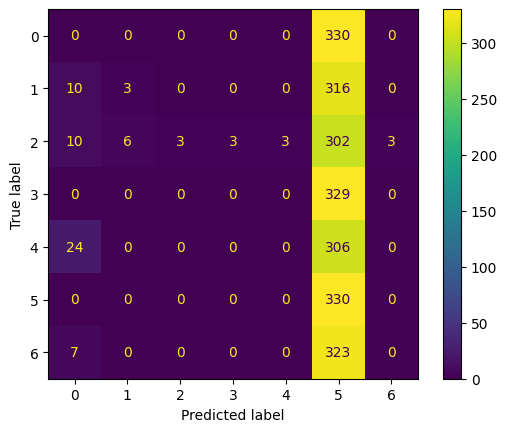

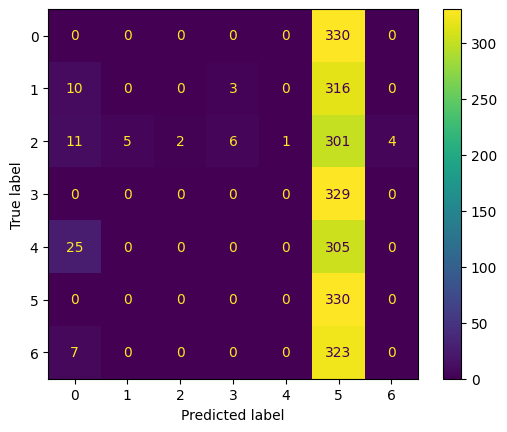

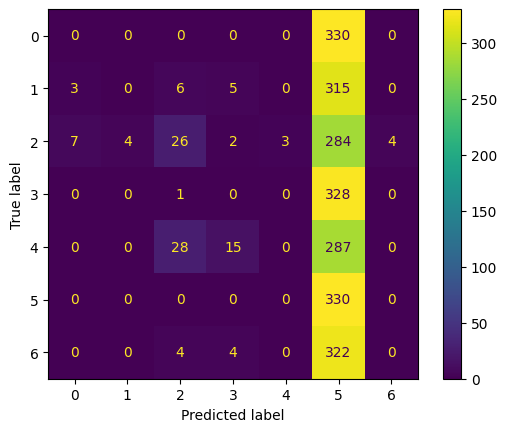

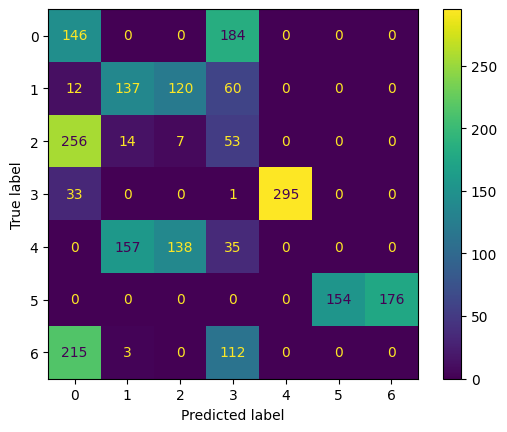

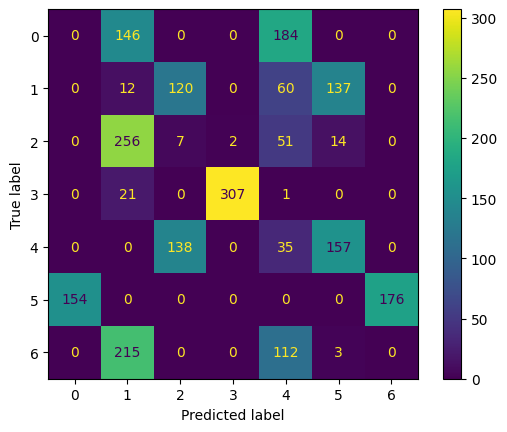

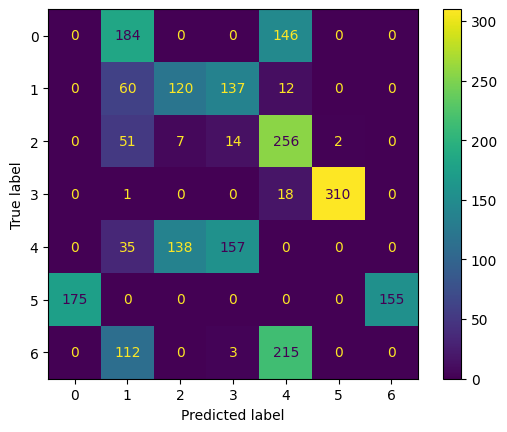

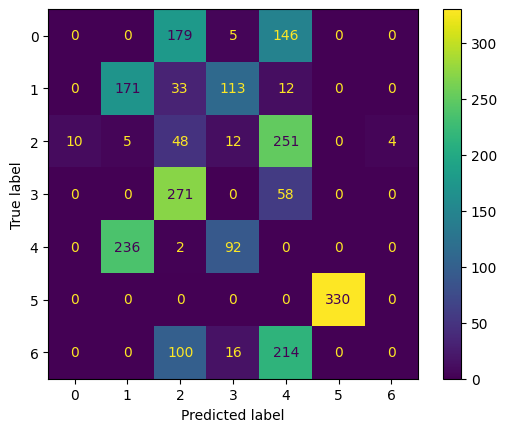

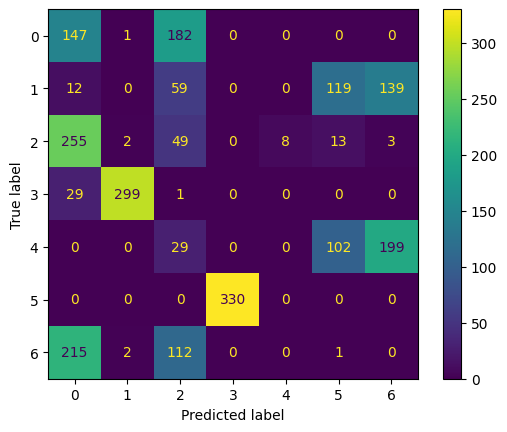

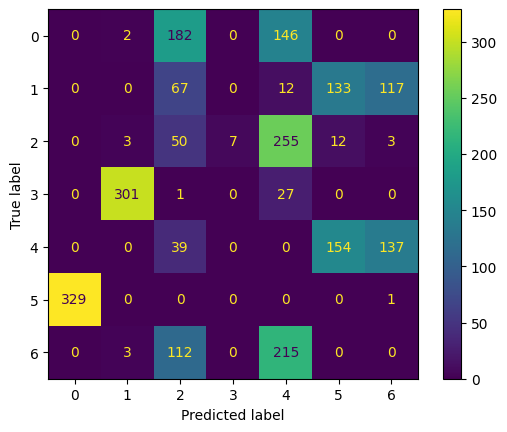

In [67]:
metrics = {'dataset': [], 'm': [], 'MPC': [], 'PE': [], 'ARI': [], 'F-M': []}

for dataset,mresults in best_results.items():
    for m,results in mresults.items():        
        mpc = modified_partition_coefficient(7,results[-1])
        pe = partition_entropy(results[1])
        c = build_crisp_partition(results[1])
        l = pd.from_dummies(c)
        y_true = L.to_numpy().flatten()
        y_pred = l.to_numpy().flatten()
        cym = contingency_matrix(y_true,y_pred)
        ari = adjusted_rand_score(y_true,y_pred)
        fm = f_measure(cym)
        cm = confusion_matrix(y_true,y_pred)
        
        metrics['dataset'].append(dataset)
        metrics['m'].append(m)
        metrics['MPC'].append(mpc)
        metrics['PE'].append(pe)
        metrics['ARI'].append(ari)
        metrics['F-M'].append(fm)
        
        ConfusionMatrixDisplay(cm).plot()
    print("\n")

metrics = pd.DataFrame(data=metrics)

In [68]:
metrics

,dataset,m,MPC,PE,ARI,F-M
0,1,1.1,0.998537,0.002157,0.000563,0.126101
1,1,1.6,0.985037,0.023425,0.000614,0.126206
2,1,2.0,0.947474,0.097341,0.001604,0.126915
3,2,1.1,0.984820,0.021760,0.377698,0.287611
4,2,1.6,0.854568,0.250481,0.390161,0.291068
5,2,2.0,0.671102,0.599251,0.393355,0.291891
6,3,1.1,0.979501,0.029664,0.365577,0.299482
7,3,1.6,0.806279,0.336610,0.443022,0.317378
8,3,2.0,0.617160,0.692518,0.432610,0.311162


In [61]:
def compare_crisp_partitions(results1, results2):
    metrics = {'ARI': [], 'F-M': []}

    c1 = build_crisp_partition(results1[1])
    l1 = pd.from_dummies(c1)
    
    c2 = build_crisp_partition(results2[1])
    l2 = pd.from_dummies(c2)
        
    y_true = l1.to_numpy().flatten()
    y_pred = l2.to_numpy().flatten()
    
    cym = contingency_matrix(y_true,y_pred)
    ari = adjusted_rand_score(y_true,y_pred)
    fm = f_measure(cym)
    cm = confusion_matrix(y_true,y_pred)
        
    metrics['ARI'].append(ari)
    metrics['F-M'].append(fm)
    
    return cm, metrics

{'ARI': [0.0009542965596485573], 'F-M': [0.14443305246166233]}


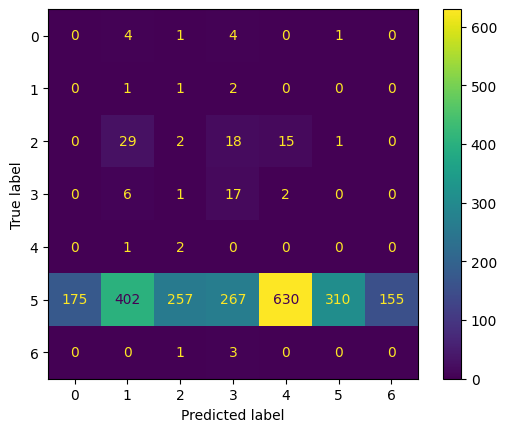

In [63]:
# Compare shape - rgb 
# m = 2

cm, metrics = compare_crisp_partitions(best_results['1']['2.0'],best_results['2']['2.0'])

print(metrics)
ConfusionMatrixDisplay(cm).plot()

{'ARI': [0.006046966184278908], 'F-M': [0.15468829322545397]}


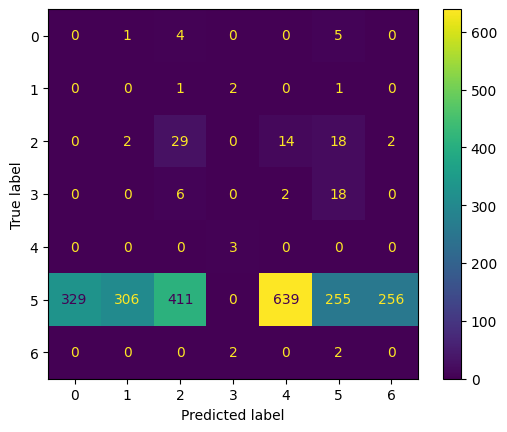

In [64]:
# Compare shape - shape+rgb 
# m = 2

cm, metrics = compare_crisp_partitions(best_results['1']['2.0'],best_results['3']['2.0'])

print(metrics)
ConfusionMatrixDisplay(cm).plot()

{'ARI': [0.9299940666661287], 'F-M': [0.4687718977017731]}


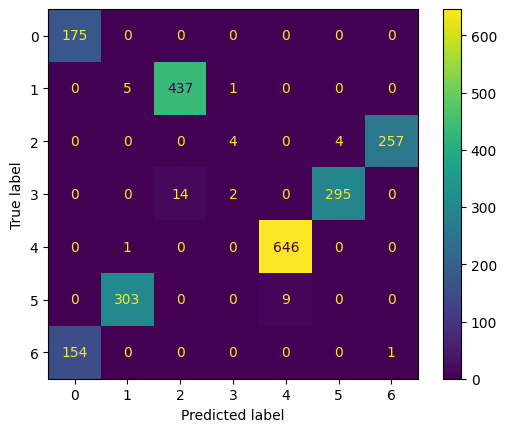

In [65]:
# Compare rgb - shape+rgb 
# m = 2

cm, metrics = compare_crisp_partitions(best_results['2']['2.0'],best_results['3']['2.0'])

print(metrics)
ConfusionMatrixDisplay(cm).plot()